# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

## Подготовка данных

### Импортирование необходимых библиотек

In [1]:
!pip install scikit-learn --upgrade

     |████████████████████████████████| 30.8 MB 47 kB/s  eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt #библиотека для построения графиков и задания определенных параметров

from sklearn import metrics
from sklearn.impute import KNNImputer

from sklearn.model_selection import train_test_split #импорт модуля разделения из специального модуля библиотеки sklearn

from sklearn.linear_model import LogisticRegression #логистическая регрессия
from sklearn.tree import DecisionTreeClassifier #импорт модуля дерева решений из специального модуля библиотеки sklearn
from sklearn.ensemble import RandomForestClassifier #импорт модуля случайного леса

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder #энкодер для замены категориальных признаков целочисленным массивом
from sklearn.preprocessing import StandardScaler #метод масштабирования по стандартным отклонениям

from sklearn.metrics import accuracy_score, f1_score #расчет метрик
from sklearn.metrics import precision_recall_curve, precision_score, recall_score #для построения кривых, рассчета метрик
from sklearn.metrics import roc_curve #для построения AUC-ROC
from sklearn.metrics import roc_auc_score

from sklearn.utils import shuffle #метод для перемешивания при upsampling


### Знакомство с данными

Признаки из датасета для обучения моделей:
- `RowNumber` — индекс строки в данных
- `CustomerId` — уникальный идентификатор клиента
- `Surname` — фамилия
- `CreditScore` — кредитный рейтинг
- `Geography` — страна проживания
- `Gender` — пол
- `Age` — возраст
- `Tenure` — сколько лет человек является клиентом банка
- `Balance` — баланс на счёте
- `NumOfProducts` — количество продуктов банка, используемых клиентом
- `HasCrCard` — наличие кредитной карты
- `IsActiveMember` — активность клиента
- `EstimatedSalary` — предполагаемая зарплата

Целевой признак:
- `Exited` — факт ухода клиента

In [16]:
# открываем таблицу:
try:
    df = pd.read_csv('/datasets/Churn.csv')
except:
    try:
        df = pd.read_csv(r'E:\Practicum\2_Projects_Git\7_learning_with_teacher_customer_outflow\Churn.csv')
    except:
        df = pd.read_csv('Churn.csv')
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


Целевой признак является категориальным, следовательно, для решения нужен алгоритм классификации.

In [4]:
df.info(); 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Видим, что в столбце `Tenure` не хватает данных: 909 строк, или 9,1% от всех данных. Для обучения модели необходимо, чтобы не было пропусков. Но столько данных мы удалить не можем. Также, для выполнения логистической регрессии необходимо, чтобы категории были выражены численными значениями.

Следовательно, нужно заполнить пробелы и преобразовать категории. Проведем предобработку данных.

### Предобработка данных

#### Проверка на дубликаты

In [5]:
df.duplicated().sum()

0

Явных дубликатов нет.

#### Удаление "лишних" данных

Удалим из датасета столбец с фамилиями, т.к. он никакого отношения к обучению не будет иметь.

Также, удалим из датасета данные `RowNumber`, т.к. это просто номер строки датасета +1.

In [6]:
df = df.drop(['Surname'], axis=1)
df = df.drop(['RowNumber'], axis=1)


#### Проверка на аномалии с помощью гистограмм

In [7]:
df.nunique() #количество уникальных значений в каждом столбце

CustomerId         10000
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

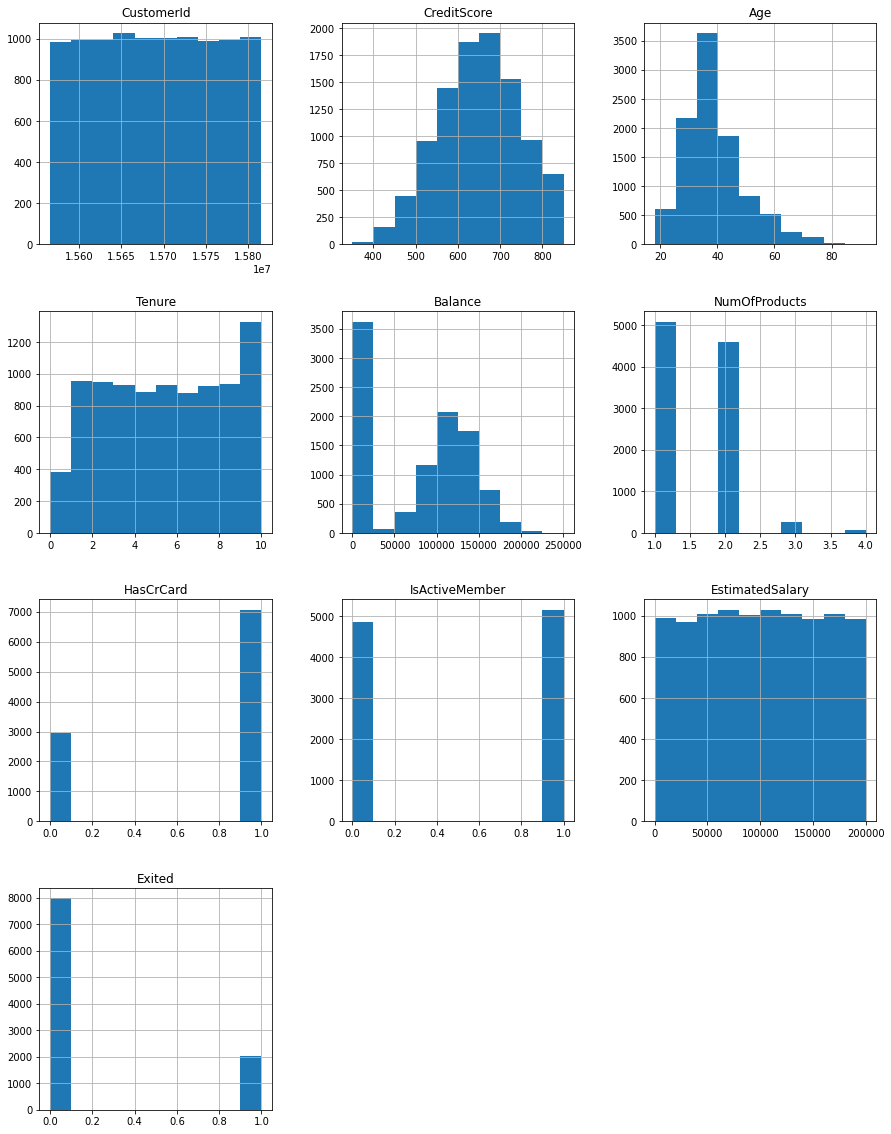

In [8]:
df.hist(figsize=(15, 20));

Учитывая, что в реальной жизни, в некоторых банках, в которых мы являемся клиентами, мы не держим на активном балансе деньги, выброс в области значения 0 столбца `Balance` выглядит правдоподобным. В остальном каких-либо аномалий не наблюдается:
- идентификаторы, ожидаемая зарплата, стаж клиента распределены равномерно,
- возраст и кредитный лимит - близкими к нормальному (или его производным) распределению. Максимальные и минимальные значения для этих параметров - адекватные,
- все остальные категориальные параметры в целом не вызывают вопросов. Не вошли в этот перечень столбцы с полом и страной. Но там никаких аномалий быть не может, т.к. в `.nunique()` мы проверили количество уникальных значений в том числе и для этих столбцов.

#### Рассматриваем пропущенные значения

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,15589475,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,15766205,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,15768193,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,15702298,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,15651280,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0


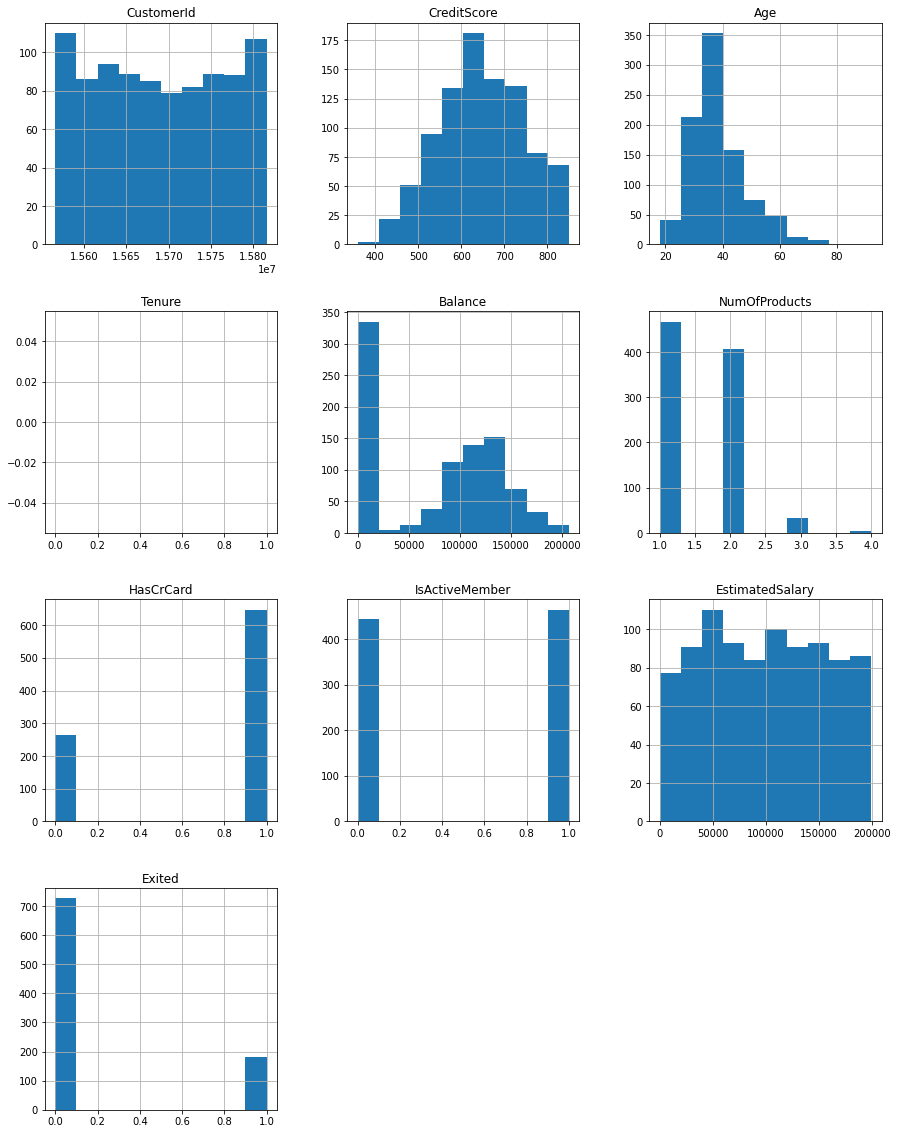

In [9]:
null_tenture_df = df[df.isnull().any(axis=1)] #отбор строк, в любом столбце которых есть пропуск
display(null_tenture_df.head()) #вывод первых 5 строк
null_tenture_df.hist(figsize=(15, 20)); #строим гистограммы

Как можно увидеть из основного набора гистограмм, данные в этой выборке практически полностью повторяют исходную совокупность. Т.к. обучение не может работать с пустыми значениями, необходимо заполнить пропуски.

Проверим несколько вариантов заполнения ячеек. На время, за которое человек является клиентом банка влияют:
- его возраст. Например, если клиенту 18 лет, то наверное, он не может быть клиентом в течение 10 лет;
- его кредитный лимит. Возможно, кредитный лимит увеличивается со стажем клиента;
- другие зависимости - проверим корреляцией параметров.

Некоторые признаки, такие как пол и др. вряд ли подскажут необходимую информацию для определения времени, за которе человек был клиентом банка.

##### Устанавливаем зависимости

Проверим предположение о возрасте:

In [10]:
df[df['Age'] == 18]['Tenure'].mean() #для 18-ти летних средний Tenure

5.05

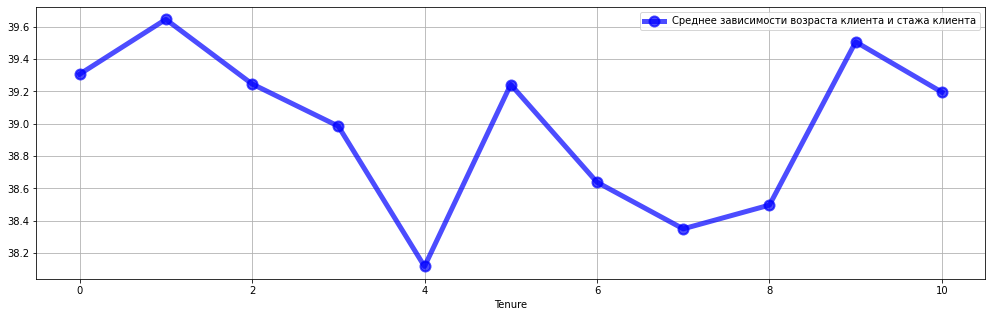

In [11]:
df_graf_mean_age = df.groupby('Tenure')['Age'].mean() #группируем возраст по Tenure

plt.figure(figsize=(17, 5)) #задаем размеры графика с помощью plt

#строим график с параметрами:
df_graf_mean_age.plot(
    x='Tenure', y='Age', #оси X и Y
    style='o-b', #стиль точки-круги, линия, синий цвет
    alpha=0.7, #прозрачность
    label="Среднее зависимости возраста клиента и стажа клиента",  #подпись для легенды
    lw=5,  #толщина линии
    mec='b',  #цвет контура точек
    mew=2,  #размер контура точек
    ms=10 #рамер точек
    )

plt.legend() #легенда
plt.grid(True) #сетка


Видим, что у 18-ти летнего клиента общий средний стаж клиента 5 лет. На графике более подробный вывод по средней зависимости возраста клиента и стажа клиента. Возраст не влияет на `Tenure`, а предположение не подтвердилось. В Европейских странах у подростков уже есть свои счета в банках.

Проверим предположение о кредитном лимите:

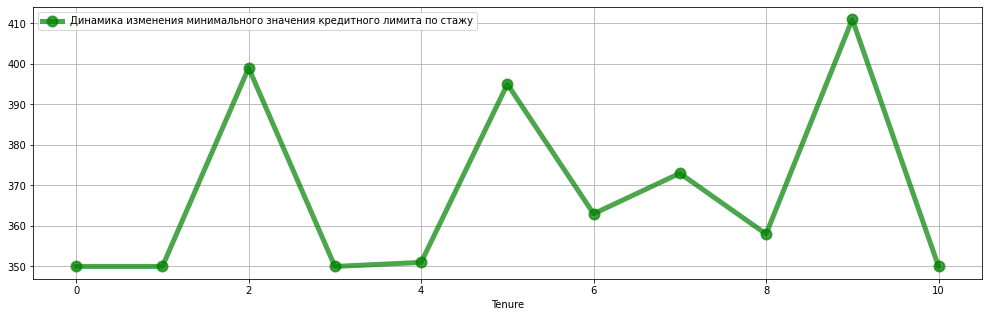

In [12]:
df_graf_min_credit = df.groupby('Tenure')['CreditScore'].min() #группируем CreditScore по Tenure

plt.figure(figsize=(17, 5))

df_graf_min_credit.plot(x='Tenure', y='CreditScore', style='o-g', alpha=0.7,
                    label="Динамика изменения минимального значения кредитного лимита по стажу", lw=5, mec='g', mew=2, ms=10)

plt.legend()
plt.grid(True)


Предположение о том, что кредитный лимит зависит от стажа не состоятельна. Низкий минимальный лимит наблюдается и при 0 лет, и при 3 годах стажа.

Чтобы не гадать о зависимостях между данными, построим карту корреляции между `Tenure` и всеми остальными признаками.

<AxesSubplot:>

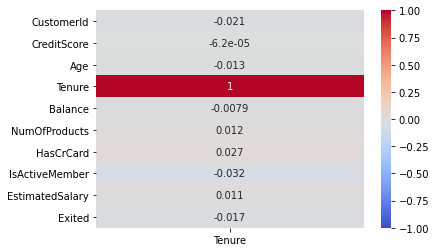

In [13]:
#с помощью sns строим тепловую карту корреляций признака Tenure ко всем остальным (выраженным численно)
sns.heatmap(df.corr()[['Tenure']], vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm')

Для всех признаков корреляция является незначительной, околонулевой. Но все же есть некоторые признаки, возможно, имеющие влияние на искомый параметр. Рассмотрим признаки с наибольшим влиянием по абсолютному значению.

In [14]:
#таблица корреляции признака Tenure к остальным, корр. выражены в абсолютных значениях, отсортированы по убыванию, выведено 5 строк
abs(df.corr()[['Tenure']].sort_values(by='Tenure', ascending=True)).head()

,Tenure
IsActiveMember,0.032178
CustomerId,0.021418
Exited,0.016761
Age,0.013134
Balance,0.007911


Рассмотрим две наибольшие по модулю корреляции: `IsActiveMember` и `CustomerId`. Ниже на графиках видно, что при увеличении значения `Tenure` для каждого параметра свойственна тенденция убывания значения. Что подтверждает отрицательная корреляция.

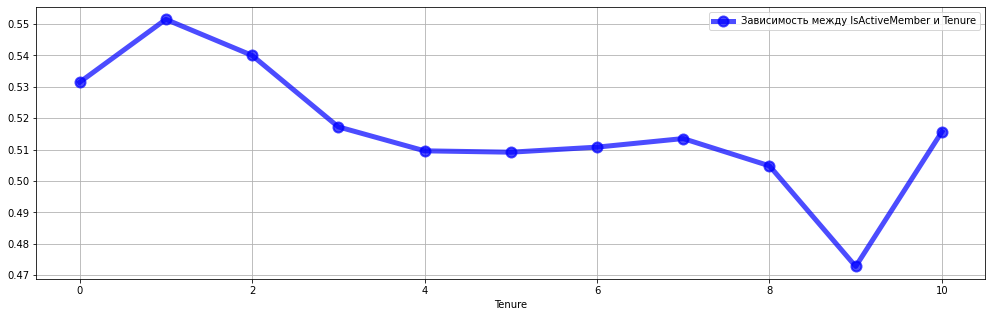

In [15]:
df_graf_id = df.groupby('Tenure')['IsActiveMember'].mean()

plt.figure(figsize=(17, 5))

df_graf_id.plot(x='Tenure', y='IsActiveMember', style='o-b', alpha=0.7,
                    label="Зависимость между IsActiveMember и Tenure", lw=5, mec='b', mew=2, ms=10)

plt.legend()
plt.grid(True)


Этот параметр тоже не даст никаких результатов, т.к. для каждого значения года, значение `IsActiveMember` колеблется в пределах 50%, клиент либо активный, либо не активный.

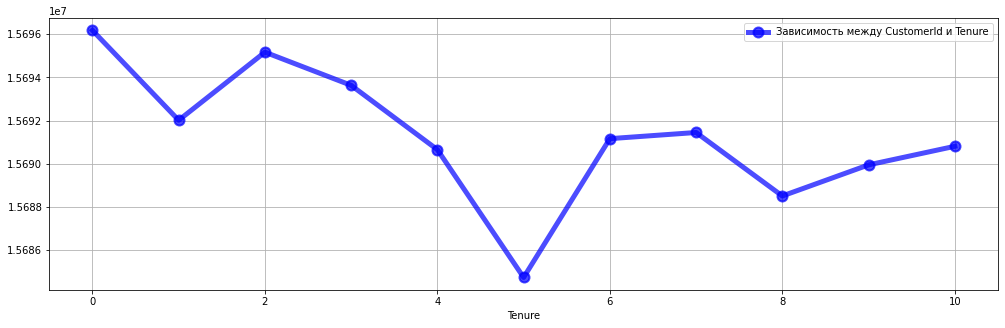

In [16]:
df_graf_id = df.groupby('Tenure')['CustomerId'].mean()

plt.figure(figsize=(17, 5))

df_graf_id.plot(x='Tenure', y='CustomerId', style='o-b', alpha=0.7,
                    label="Зависимость между CustomerId и Tenure", lw=5, mec='b', mew=2, ms=10)

plt.legend()
plt.grid(True)


Если бы идентификатор имел отношение к `Tenure`, тогда бы это была строго убывающая функция (чем дольше клиент - тем меньше номер идентификатора). Значит, этот признак тоже не подходит для определения `Tenure`.

Ни одно из изначальных предположений не подтвердилось. Для дальнейшего расчета будем считать клиентов с пропущенным значением `Tenure` - новыми, со значением `Tenure` = 0.

##### Заполняем пропуски

Есть много способов заполнить данные, некоторые из них:
- заполнить нулями,
- заполнить каким-нибудь значением (обычно медианой),
- применить какой-либо метод, считающий приблизительные данные.

Ранее было решено, что данные по отдельности слабо коррелируют или не коррелируют вовсе с `Tenure`.

Проверим, как будет заполнен данными столбец без изменения, с 0 вместо пропуска и с медианным значением вместо пропуска:

In [17]:
df_tenure_empty = df['Tenure'] #создаем объект series без изменения
df_tenure_empty = df_tenure_empty.rename("Tenure_empty") #переименовываем столбец

df_tenure_zero = df['Tenure'].fillna(0) #создаем объект series, заполняя пропуски 0
df_tenure_zero = df_tenure_zero.rename("Tenure_zero") #переименовываем столбец

df_tenure_median = df['Tenure'].fillna(df['Tenure'].median()) #создаем объект series заполняя пропуски медианой
df_tenure_median = df_tenure_median.rename("Tenure_median") #переименовываем столбец

#создаем из нескольких series датасет
df_tenure_full = pd.concat([df_tenure_empty, df_tenure_zero, df_tenure_median], axis=1)
df_tenure_full

,Tenure_empty,Tenure_zero,Tenure_median
0,2.0,2.0,2.0
1,1.0,1.0,1.0
2,8.0,8.0,8.0
3,1.0,1.0,1.0
4,2.0,2.0,2.0
...,...,...,...
9995,5.0,5.0,5.0
9996,10.0,10.0,10.0
9997,7.0,7.0,7.0
9998,3.0,3.0,3.0


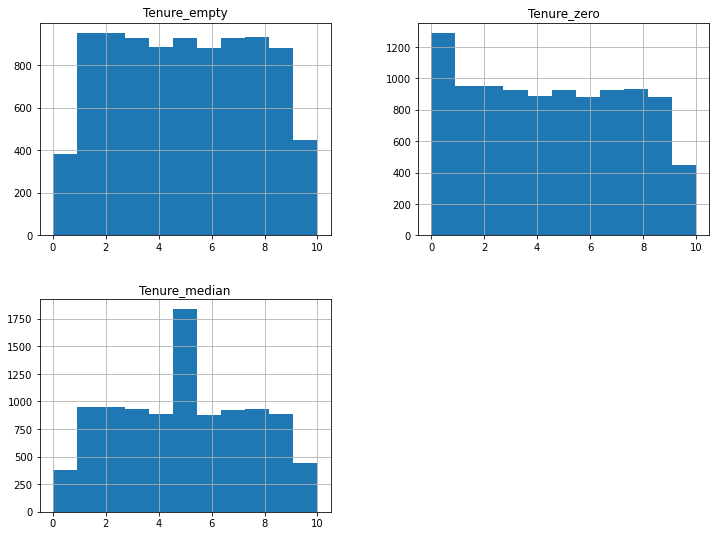

In [18]:
df_tenure_full.hist(bins=11, figsize=(12, 9)); #показываем гистограммы

Здесь мы видим, насколько изменились данные - появились выбросы там, где их не было. Нулями мы тоже не можем заполнить, т.к. это не точный показатель - потому что нулевые значения в датасете тоже были.

Посмотрим информацию по датасетам:

In [19]:
display(df_tenure_full.describe()); #описание данных

,Tenure_empty,Tenure_zero,Tenure_median
count,9091.000000,10000.000000,10000.00000
mean,4.997690,4.543400,4.99790
std,2.894723,3.111573,2.76001
min,0.000000,0.000000,0.00000
25%,2.000000,2.000000,3.00000
50%,5.000000,4.000000,5.00000
75%,7.000000,7.000000,7.00000
max,10.000000,10.000000,10.00000


Видим, что медиана, несмотря на то, что делает выброс на значении 5, намного ближе по параметрам к исходным данным (у нее почти такое же среднее, не сильно изменяется и стандартное отклонение). Единственное значение, которое сильно исказилось - это 25% - нижняя граница ящика с усами. Она изменится при любом ненулевом заполнении данными.

Таким образом, разумно будет заполнить пропущенные значения медианой.

In [20]:
df['Tenure'] = df['Tenure'].fillna(5) #заполняем пропуски 0

На этом предобработка данных завершена. Переходим к этапу машинного обучения.

## Исследование задачи

### Преобразование

#### Разбиение данных

Разобьем датасет на 3 выборки:
- тренировочную - на которой мы обучаьем модели,
- валидационную - на которой они проходят проверку качества,
- тестовую - на которой проверяется полученная модель.

Делить будем в пропорции 60/20/20. Так как метод `train_test_split` делит исходную выборку на две, а в аргументе `test_size` указывается доля размера для второй выборки, то при первой итерации `test_size` примет значение 0.4 (0.2+0.2), а во второй итерации - значение 0.5 (т.к. будем делить выборки поровну).

In [21]:
RANDOM_STATE = 1 #выносим константную переменную
#разделение исходного датасета на две выборки, обучающую и временную валидационную
df_train, df_temp = train_test_split(df, test_size=0.4, random_state=RANDOM_STATE) 
#разделение временной выборки на валидационную и тестовую
df_valid, df_test = train_test_split(df_temp, test_size=0.5, random_state=RANDOM_STATE) 

#### Признаки для обучения

In [22]:
features_train = df_train.drop(['Exited'], axis=1) #признаки
target_train = df_train['Exited'].reset_index(drop=True) #целевой признак (сбрасываем индекс, потом будет нужно)

features_valid = df_valid.drop(['Exited'], axis=1) #признаки
target_valid = df_valid['Exited'].reset_index(drop=True) #целевой признак

features_test = df_test.drop(['Exited'], axis=1) #признаки
target_test = df_test['Exited'].reset_index(drop=True) #целевой признак

#### Прямое кодирование

Для обучения модели необходимо, чтобы значения во всех столбцах были выражены числами, в том числе и категории. 

С помощью метода `OneHotEncoder()` сделаем столбцы с полом и географией категориальными числовыми, и удалим один зависимый столбец (первый).

In [23]:
ohe_train = OneHotEncoder(handle_unknown='ignore',sparse=False) #применяем OneHotEncoder
ohe_train.set_params(drop= 'first') #применяем параметр удалить первый столбец

#обучаем и сразу трансформируем обучающую выборку, столбцы 'Gender','Geography'
features_train_ohe = ohe_train.fit_transform(features_train.loc[:,['Gender','Geography']]) 
features_valid_ohe = ohe_train.transform(features_valid.loc[:,['Gender','Geography']]) #трансформируем
features_test_ohe = ohe_train.transform(features_test.loc[:,['Gender','Geography']]) #трансформируем
ohe_train.get_params() #смотрим параметры

{'categories': 'auto',
 'drop': 'first',
 'dtype': numpy.float64,
 'handle_unknown': 'ignore',
 'max_categories': None,
 'min_frequency': None,
 'sparse': False}

In [24]:
ohe_train.get_feature_names_out() #смотрим имена столбцов (как видим, нет первых - Женщин и Франции)

array(['Gender_Male', 'Geography_Germany', 'Geography_Spain'],
      dtype=object)

In [25]:
#удаляем столбцы 'Geography', 'Gender', сбрасываем индексы
features_train_temp = features_train.drop(['Geography', 'Gender'], axis=1).reset_index(drop=True)
features_valid_temp = features_valid.drop(['Geography', 'Gender'], axis=1).reset_index(drop=True)
features_test_temp = features_test.drop(['Geography', 'Gender'], axis=1).reset_index(drop=True)

In [26]:
#преобразовываем массивы в датафреймы со столбцами из перечня. индексы у них уже сброшены
array_temp_features_train_ohe = pd.DataFrame(features_train_ohe, columns =['Gender_Male',
       'Geography_Germany', 'Geography_Spain'])
array_temp_features_valid_ohe = pd.DataFrame(features_valid_ohe, columns =['Gender_Male',
       'Geography_Germany', 'Geography_Spain'])
array_temp_features_test_ohe = pd.DataFrame(features_test_ohe, columns =['Gender_Male',
       'Geography_Germany', 'Geography_Spain'])

In [27]:
#для каждой выборки признаков склеиваем с новыми данными из массива. т.к. все индексы сброшены, перемешивания не будет.
features_train = pd.concat([features_train_temp, array_temp_features_train_ohe], axis=1)
features_valid = pd.concat([features_valid_temp, array_temp_features_valid_ohe], axis=1)
features_test = pd.concat([features_test_temp, array_temp_features_test_ohe], axis=1)

#перемешаем выборки
features_train, target_train = shuffle(features_train, target_train, random_state=RANDOM_STATE)
features_valid, target_valid = shuffle(features_valid, target_valid, random_state=RANDOM_STATE)
features_test, target_test = shuffle(features_test, target_test, random_state=RANDOM_STATE)


#### Масштабирование признаков

Объединим все количественные признаки:

In [28]:
numeric = ['CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [29]:
scaler = StandardScaler() #вводим скейлер
scaler.fit(features_train[numeric]) #обучаем на тестовой выборке
features_train[numeric] = scaler.transform(features_train[numeric]) #трансформируем выборки
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

#### Пробное обучение

In [30]:
model_check = LogisticRegression(random_state=RANDOM_STATE)
model_check.fit(features_train, target_train) 

LogisticRegression(random_state=1)

Ошибки нет, следовательно, входные данные для обучения корректны. На этом преобразование завершено.

### Баланс классов

In [31]:
# Создаем датасет со значениями баланса классов
model_list = [
    'обучающей выборки', 
    'валидационной выборки', 
    'тестовой выборки'
    ]
    
zero_list = [
    target_train.value_counts(normalize=True)[0], #нулевой класс
    target_valid.value_counts(normalize=True)[0], 
    target_test.value_counts(normalize=True)[0]
    ]

one_list = [
    target_train.value_counts(normalize=True)[1], #первый класс
    target_valid.value_counts(normalize=True)[1], 
    target_test.value_counts(normalize=True)[1]
    ]

balance_class = pd.DataFrame({ #созаем датафрейм
    'Баланс классов': model_list, #
    'Значение 0-класса': zero_list, #
    'Значение 1-класса': one_list, 
}) #

balance_class = balance_class.set_index('Баланс классов')
balance_class

,Значение 0-класса,Значение 1-класса
Баланс классов,,
обучающей выборки,0.800667,0.199333
валидационной выборки,0.789500,0.210500
тестовой выборки,0.790000,0.210000


Имеем большой дисбаланс классов, в среднем 80:20 % отношение 0:1.

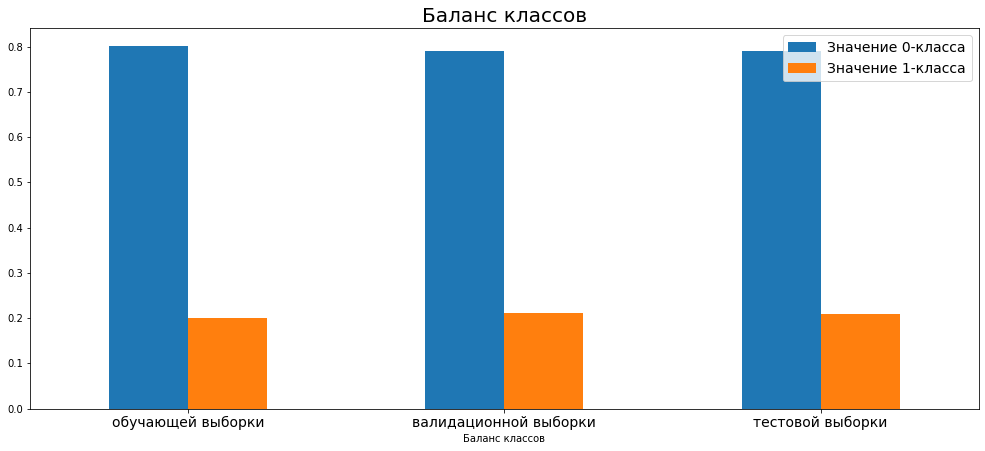

In [32]:
balance_class.plot(kind='bar', figsize=(17, 7))

bw = 0.5 #толщина столбика
plt.title('Баланс классов', fontsize=20) #имя графика
plt.xticks(fontsize=14, rotation=0) #показать подпись, убрать поворот
plt.legend(fontsize=14); #показать легенду

### Обучение моделей

#### Логистическая регрессия

In [33]:
log_reg = LogisticRegression(random_state=RANDOM_STATE) #вводим логистическую регрессию
log_reg.fit(features_train, target_train) #обучаем модель на тестовых
prediction_log_reg = log_reg.predict(features_valid) #предсказываем по валидационным
f1_log_reg = f1_score(target_valid, prediction_log_reg)
accuracy_log_reg = accuracy_score(target_valid, prediction_log_reg)
print("F1:", f1_log_reg) #находим метрику F1
print("Accuracy:", accuracy_log_reg) #находим метрику Accuracy

F1: 0.323943661971831
Accuracy: 0.808


`AUC-ROC` - это площадь под кривой (метрик доли ложноположительных ответов (`FPR`), отсчитывающейся по оси X, и доли истинно положительных ответов (`TPR`)).

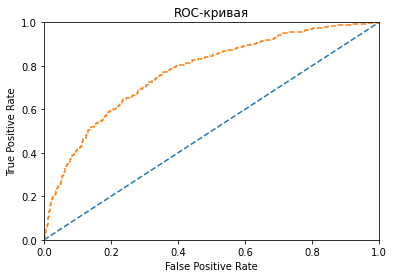

In [34]:
log_reg_pred_one = log_reg.predict_proba(features_valid)[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, log_reg_pred_one)

plt.figure()

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.plot(fpr, tpr, linestyle='--')

plt.show()

In [35]:
roc_auc_log_reg = roc_auc_score(target_valid, log_reg_pred_one) #значение roc_auc
roc_auc_log_reg

0.7717894755843847

Значение F1 невысокое. Площадь `AUC-ROC` - маленькая.

#### Дерево решений

In [36]:
accuracy_valid_trees_list = [] #создаем пустой список accuracy
f1_valid_trees_list = [] #создаем пустой список f1
roc_auc_score_list = []

for depth in range(1, 16): #цикл для глубины дерева, до 15
    model_trees = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth) #модель дерева решений с меняющейся глубиной
    model_trees.fit(features_train, target_train) #обучение модели на тренировочной выборке
    predictions_trees_valid = model_trees.predict(features_valid) #предсказание целевого признака на основе валидационных признаков
    accuracy_valid_trees = accuracy_score(target_valid, predictions_trees_valid) #accuracy
    accuracy_valid_trees_list.append(accuracy_valid_trees) #добавление оценки точности в список
    f1_valid_trees = f1_score(target_valid, predictions_trees_valid) #f1 метрика
    f1_valid_trees_list.append(f1_valid_trees) #добавление оценки f1 в список
    trees_roc_auc_score = roc_auc_score(target_valid, model_trees.predict_proba(features_valid)[:, 1]) #значение roc_auc
    roc_auc_score_list.append(trees_roc_auc_score)

depth_list = list(range(1, 16)) #создаем список значений глубины дерева
df_trees = pd.DataFrame({ #созаем датафрейм
    'Depth': depth_list, #глубина - из списка
    'accuracy_valid_trees': accuracy_valid_trees_list, #качество тренировочных данных
    'f1_valid_trees': f1_valid_trees_list,
    'roc_auc_score': roc_auc_score_list
    
}) #

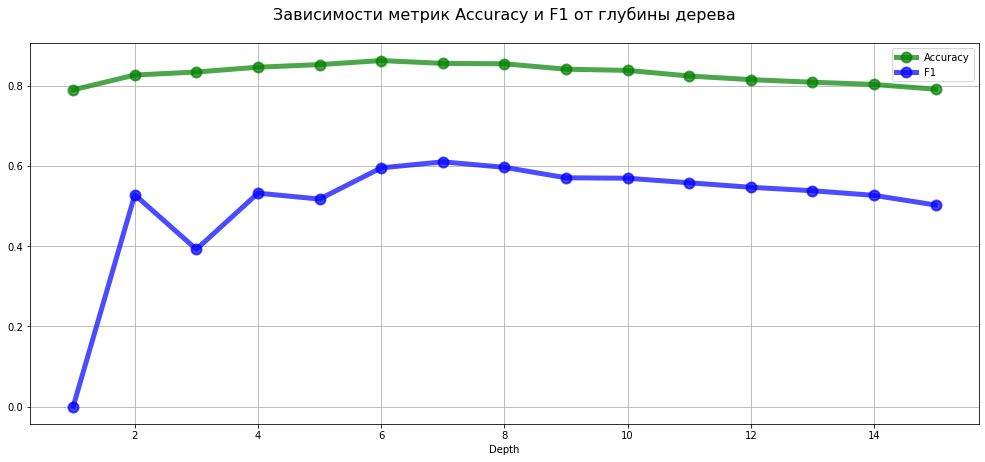

In [37]:
ax = df_trees.plot( #строим график plot
    x='Depth', y='accuracy_valid_trees', #оси Х и Y
    style='o-g', sharex=False, grid=True, alpha=0.7, #линия с точками, сетка, прозрачность 0.7
    label="Accuracy", #легенда
    lw=5, mew=2, ms=10, figsize=(17, 7)); #толщина линии, величина точек, размеры графика

df_trees.plot(
    x='Depth', y='f1_valid_trees', style='o-b', sharex=False, grid=True,
    alpha=0.7, label="F1",
    lw=5, mew=2, ms=10, figsize=(17, 7), ax=ax)\
.set_title(
    'Зависимости метрик Accuracy и F1 от глубины дерева' + "\n", #название графика
    fontsize = 16, color = 'Black'); #размер шрифта, цвет

In [38]:
df_trees.sort_values(by='f1_valid_trees', ascending=False).head() #вывод отсортированного датасета с результатами, обучен на дереве

,Depth,accuracy_valid_trees,f1_valid_trees,roc_auc_score
6,7,0.8555,0.609987,0.845711
7,8,0.8545,0.596394,0.823908
5,6,0.8625,0.594993,0.847044
8,9,0.8410,0.570270,0.787611
9,10,0.8380,0.569149,0.758552


#### Случайный лес

In [39]:
accuracy_valid_forest_list = [] #создаем пустой список accuracy
f1_valid_forest_list = [] #создаем пустой список f1
roc_auc_score_list = []

for value in range(1, 31): #цикл для глубины дерева, до 30
    model_forest = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=value) #модель леса с меняющимся количеством деревьев
    model_forest.fit(features_train, target_train) #обучение модели на тренировочной выборке
    predictions_forest_valid = model_forest.predict(features_valid) #предсказание на основе валидационных признаков
    accuracy_valid_forest = accuracy_score(target_valid, predictions_forest_valid) #accuracy метрика
    accuracy_valid_forest_list.append(accuracy_valid_forest) #добавление в список
    f1_valid_forest = f1_score(target_valid, predictions_forest_valid) #f1 метрика
    f1_valid_forest_list.append(f1_valid_forest) #добавление в список
    forest_roc_auc_score = roc_auc_score(target_valid, model_forest.predict_proba(features_valid)[:, 1]) #значение roc_auc
    roc_auc_score_list.append(forest_roc_auc_score)

estimator_list = list(range(1, 31)) #создаем список значений количества деревьев
df_forest = pd.DataFrame({ #созаем датафрейм
    'estimator': estimator_list, #количество - из списка
    'accuracy_valid_forest': accuracy_valid_forest_list, #к
    'f1_valid_forest': f1_valid_forest_list, #
    'roc_auc_score': roc_auc_score_list

}) #

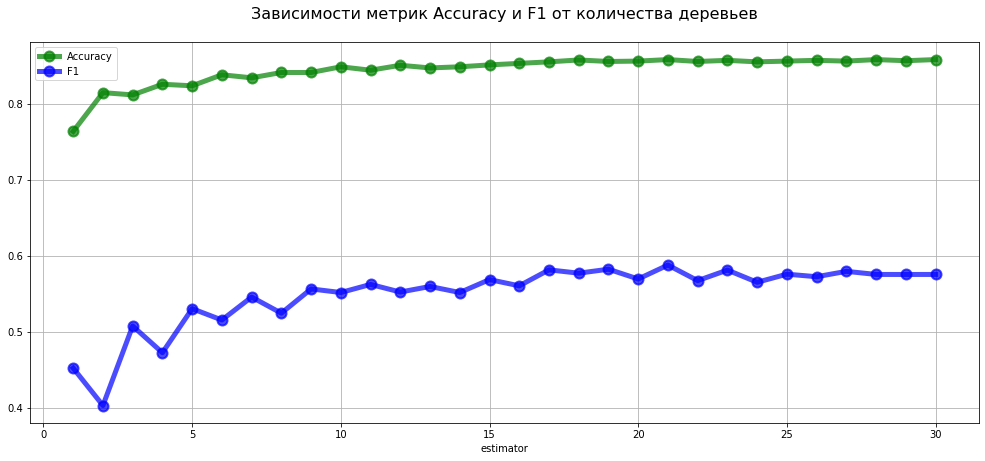

In [40]:
ax = df_forest.plot( #строим график plot
    x='estimator', y='accuracy_valid_forest', #оси Х и Y
    style='o-g', sharex=False, grid=True, alpha=0.7, #линия с точками, сетка, прозрачность 0.7
    label="Accuracy", #легенда
    lw=5, mew=2, ms=10, figsize=(17, 7)); #толщина линии, величина точек, размеры графика

df_forest.plot(
    x='estimator', y='f1_valid_forest', style='o-b', sharex=False, grid=True,
    alpha=0.7, label="F1",
    lw=5, mew=2, ms=10, figsize=(17, 7), ax=ax)\
.set_title(
    'Зависимости метрик Accuracy и F1 от количества деревьев' + "\n", #название графика
    fontsize = 16, color = 'Black'); #размер шрифта, цвет

In [41]:
df_forest.sort_values(by='f1_valid_forest', ascending=False).head() #вывод отсортированного датасета с результатами, обучен на лесе

,estimator,accuracy_valid_forest,f1_valid_forest,roc_auc_score
20,21,0.8585,0.588064,0.829789
18,19,0.8560,0.582609,0.828098
16,17,0.8555,0.581766,0.821714
22,23,0.8575,0.581498,0.833432
26,27,0.8565,0.579795,0.836796


#### Случайный лес с глубиной

In [42]:
f1_valid_forest0 = -0.1 #задаем параметры для циклов. отрицательная f1
best_est = 0 #деревьев 0
best_depth = 0 #глубина 0
best_accuracy = 0 #
for est in range(1, 31, 5): #количество деревьев варьируем от 1 до 30 с шагом 5
    for depth in range (1, 20): #глубина
        model_forest_depth = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=est, max_depth=depth) #модель леса с меняющимся количеством деревьев и глубиной
        model_forest_depth.fit(features_train, target_train) #обучение модели на тренировочной выборке
        predictions_forest_depth_valid = model_forest_depth.predict(features_valid) #предсказание на основе валидационных признаков
        accuracy_valid_forest_depth = accuracy_score(target_valid, predictions_forest_depth_valid) #accuracy
        f1_valid_forest_depth = f1_score(target_valid, predictions_forest_depth_valid) #f1
        if f1_valid_forest_depth > f1_valid_forest0: #сравнение с начальным значением, если удовлетворяет, то:
            f1_valid_forest0 = f1_valid_forest_depth #переназначаем начальное значение
            best_est = est #количество
            best_depth = depth #глубина
            best_accuracy = accuracy_valid_forest_depth #
print("F1:", f1_valid_forest0, '\nAccuracy:', best_accuracy, '\nEstimators:', best_est, '\nDepth:', best_depth) #вывод

F1: 0.6014814814814815 
Accuracy: 0.8655 
Estimators: 21 
Depth: 15


Здесь, максимальное значение метрики F1 достигается при количестве деревьев равном 21 и глубине равной 15.

In [43]:
model_forest_depth = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=21, max_depth=15) 
model_forest_depth.fit(features_train, target_train)
roc_auc_score(target_valid, model_forest_depth.predict_proba(features_valid)[:, 1]) #значение roc_auc

0.8377005802102717

Сделаем классификатор для случайного леса, для того, чтобы оценить важность каждого признака на обучение:

In [44]:
classifier = RandomForestClassifier(random_state=RANDOM_STATE) #вводим классификатор для модели случайного леса
classifier.fit(features_train, target_train) #обучаем на тренировочной
fi = classifier.feature_importances_ #классификация важности признаков

#создаем объект Series и сортируем по убыванию важности
importance = pd.Series(fi, index=features_train.columns).sort_values(ascending=False)
importance

Age                  0.218466
EstimatedSalary      0.124181
Balance              0.123555
NumOfProducts        0.119991
CustomerId           0.118493
CreditScore          0.114603
Tenure               0.068992
IsActiveMember       0.038423
Geography_Germany    0.025936
Gender_Male          0.018192
HasCrCard            0.016573
Geography_Spain      0.012595
dtype: float64

По предварительному обучению имеем такие показатели:

In [45]:
# Создаем датасет с набором полученных ранее значений.

model_list = [
    'Логистическая регрессия', 
    'Дерево решений', 
    'Случайный лес', 
    'Случайный лес с глубиной'
    ]
    
f1_list = [
    f1_log_reg, 
    df_trees['f1_valid_trees'].max(), 
    df_forest['f1_valid_forest'].max(), 
    f1_valid_forest0
    ]

accuracy_list = [
    accuracy_log_reg, 
    df_trees.sort_values(by='f1_valid_trees', ascending=False).head(1)['accuracy_valid_trees'].max(), 
    df_forest.sort_values(by='f1_valid_forest', ascending=False).head(1)['accuracy_valid_forest'].max(), 
    best_accuracy
    ]

depth_list = [
    '-', 
    df_trees.sort_values(by='f1_valid_trees', ascending=False).head(1)['Depth'].max(), 
    '-', 
    best_depth
    ]

estimators_list = [
    '-', 
    '-', 
    df_forest.sort_values(by='f1_valid_forest', ascending=False).head(1)['estimator'].max(), 
    best_est
    ]

auc_roc_list = [
    roc_auc_log_reg, 
    df_trees.sort_values(by='f1_valid_trees', ascending=False).head(1)['roc_auc_score'].max(), 
    df_forest.sort_values(by='f1_valid_forest', ascending=False).head(1)['roc_auc_score'].max(), 
    roc_auc_score(target_valid, model_forest_depth.predict_proba(features_valid)[:, 1])
    ]

df_pred_results = pd.DataFrame({ #созаем датафрейм
    'Model': model_list, #глубина - из списка
    'F1': f1_list, #качество валидационных данных
    'Accuracy': accuracy_list, #качество тренировочных данных
    'Depth': depth_list,
    'Estimators': estimators_list,
    'AUC-ROC': auc_roc_list
}) #

df_pred_results

,Model,F1,Accuracy,Depth,Estimators,AUC-ROC
0,Логистическая регрессия,0.323944,0.8080,-,-,0.771789
1,Дерево решений,0.609987,0.8555,7,-,0.845711
2,Случайный лес,0.588064,0.8585,-,21,0.829789
3,Случайный лес с глубиной,0.601481,0.8655,15,21,0.837701


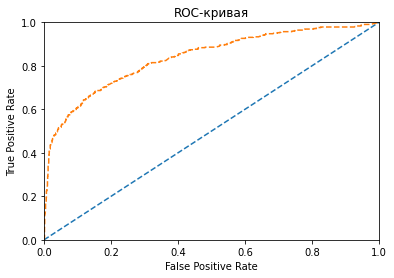

In [46]:
probabilities_valid = model_forest_depth.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.plot(fpr, tpr, linestyle='--')

plt.show()

Линия молели вытянута вверх больше, чем в случае логистической регресси, а значит, модель дает больше истинноположительных предсказаний.

Наилучшая F1 у дерева решений, так же как и Accuracy и метрики `AUC-ROC`.

### Выводы по результатам исследования задачи

На данном этапе проведена предобработка данных, а также датасет был подготовлен к обучению:
- прямым кодированием номинальные категориальные признаки изменены на числовые категориальные,
- данные разделены на выборки в необходимой пропорции,
- признаки масштабированы,
- оценен баланс классов для целевого признака,
- обучены разные модели, некоторые с перебором параметров.

На данном этапе получено максимальное значение F1 метрики для модели дерева решений с глубиной 7.

Значение F1 метрики равно 0.61, Accuracy 0.856. Значение `AUC-ROC` 0.846, построен график.

## Борьба с дисбалансом

### Взвешивание классов

#### Логистическая регрессия

In [47]:
log_reg_bal = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', class_weight='balanced') #вводим логистическую регрессию
log_reg_bal.fit(features_train, target_train) #обучаем модель на тестовых
predictions_log_reg_bal = log_reg_bal.predict(features_valid) #предсказываем по валидационным
f1_log_reg_bal = f1_score(target_valid, predictions_log_reg_bal)
accuracy_log_reg_bal = accuracy_score(target_valid, predictions_log_reg_bal)
print("F1:", f1_log_reg_bal) #находим метрику F1
print("Accuracy:", accuracy_log_reg_bal) #находим метрику Accuracy

F1: 0.5080440304826418
Accuracy: 0.7095


In [48]:
roc_auc_log_reg_bal = roc_auc_score(target_valid, log_reg_bal.predict_proba(features_valid)[:, 1]) #значение roc_auc
roc_auc_log_reg_bal

0.7760722306881139

Значение F1 выросло почти в 2 раза, благодаря балансировке. Значение метрики `roc_auc_score` практически не изменилось.

#### Дерево решений

In [49]:
accuracy_valid_trees_list = [] #создаем пустой список accuracy
f1_valid_trees_list = [] #создаем пустой список f1
roc_auc_score_list = []

for depth in range(1, 16): #цикл для глубины дерева, до 15
    model_trees = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth, class_weight='balanced') #модель дерева решений с меняющейся глубиной
    model_trees.fit(features_train, target_train) #обучение модели на тренировочной выборке
    predictions_trees_valid = model_trees.predict(features_valid) #предсказание целевого признака на основе валидационных признаков
    accuracy_valid_trees = accuracy_score(target_valid, predictions_trees_valid) #accuracy
    accuracy_valid_trees_list.append(accuracy_valid_trees) #добавление оценки точности в список
    f1_valid_trees = f1_score(target_valid, predictions_trees_valid) #f1 метрика
    f1_valid_trees_list.append(f1_valid_trees) #добавление оценки f1 в список
    trees_roc_auc_score = roc_auc_score(target_valid, model_trees.predict_proba(features_valid)[:, 1]) #значение roc_auc
    roc_auc_score_list.append(trees_roc_auc_score)

depth_list = list(range(1, 16)) #создаем список значений глубины дерева
df_trees_bal = pd.DataFrame({ #созаем датафрейм
    'Depth': depth_list, #глубина - из списка
    'accuracy_valid_trees': accuracy_valid_trees_list, #качество тренировочных данных
    'f1_valid_trees': f1_valid_trees_list, #качество валидационных данных
    'roc_auc_score': roc_auc_score_list
}) 

df_trees_bal.sort_values(by='f1_valid_trees', ascending=False).head(1) #вывод отсортированного датасета с результатами, обучен на дереве

,Depth,accuracy_valid_trees,f1_valid_trees,roc_auc_score
6,7,0.779,0.593002,0.843009


#### Случайный лес

In [50]:
accuracy_valid_forest_list = [] #создаем пустой список accuracy
f1_valid_forest_list = [] #создаем пустой список f1
roc_auc_score_list = []

for value in range(1, 31): #цикл для глубины дерева, до 30
    model_forest = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=value, class_weight='balanced') #модель леса с меняющимся количеством деревьев
    model_forest.fit(features_train, target_train) #обучение модели на тренировочной выборке
    predictions_forest_valid = model_forest.predict(features_valid) #предсказание на основе валидационных признаков
    accuracy_valid_forest = accuracy_score(target_valid, predictions_forest_valid) #accuracy метрика
    accuracy_valid_forest_list.append(accuracy_valid_forest) #добавление в список
    f1_valid_forest = f1_score(target_valid, predictions_forest_valid) #f1 метрика
    f1_valid_forest_list.append(f1_valid_forest) #добавление в список
    forest_roc_auc_score = roc_auc_score(target_valid, model_forest.predict_proba(features_valid)[:, 1]) #значение roc_auc
    roc_auc_score_list.append(forest_roc_auc_score)

estimator_list = list(range(1, 31)) #создаем список значений количества деревьев
df_forest_bal = pd.DataFrame({ #созаем датафрейм
    'estimator': estimator_list, #количество - из списка
    'accuracy_valid_forest': accuracy_valid_forest_list, #к
    'f1_valid_forest': f1_valid_forest_list, #
    'roc_auc_score': roc_auc_score_list
}) #

df_forest_bal.sort_values(by='f1_valid_forest', ascending=False).head(1) #вывод отсортированного датасета с результатами, обучен на лесе

,estimator,accuracy_valid_forest,f1_valid_forest,roc_auc_score
10,11,0.856,0.582609,0.826596


#### Случайный лес с глубиной

In [51]:
f1_valid_forest_bal = -0.1 #задаем параметры для циклов. отрицательная f1
best_est_bal = 0 #деревьев 0
best_depth_bal = 0 #глубина 0
best_accuracy_bal = 0 #
for est in range(51, 71, 5): #количество деревьев варьируем от 1 до 30 с шагом 5
    for depth in range (1, 15): #глубина
        model_forest_depth = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=est, max_depth=depth, class_weight='balanced') #модель леса с меняющимся количеством деревьев и глубиной
        model_forest_depth.fit(features_train, target_train) #обучение модели на тренировочной выборке
        predictions_forest_depth_valid = model_forest_depth.predict(features_valid) #предсказание на основе валидационных признаков
        accuracy_valid_forest_depth = accuracy_score(target_valid, predictions_forest_depth_valid) #accuracy
        f1_valid_forest_depth = f1_score(target_valid, predictions_forest_depth_valid) #f1
        if f1_valid_forest_depth > f1_valid_forest_bal: #сравнение с начальным значением, если удовлетворяет, то:
            f1_valid_forest_bal = f1_valid_forest_depth #переназначаем начальное значение
            best_est_bal = est #количество
            best_depth_bal = depth #глубина
            best_accuracy_bal = accuracy_valid_forest_depth #
print("F1:", f1_valid_forest_bal, '\nAccuracy:', best_accuracy_bal, '\nEstimators:', best_est_bal, '\nDepth:', best_depth_bal) #вывод

F1: 0.6407766990291263 
Accuracy: 0.8335 
Estimators: 66 
Depth: 8


Заранее проведя расчет очень крупного леса, берем диапазон значений `est`, дающий значение `F1`, близкое к максимальному. Метрика F1 увеличилась до 0.641, благодаря балансировке классов.

In [52]:
model_forest_depth = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=66, max_depth=8, class_weight='balanced') 
model_forest_depth.fit(features_train, target_train)
roc_auc_score_for_bal = roc_auc_score(target_valid, model_forest_depth.predict_proba(features_valid)[:, 1]) #значение roc_auc
roc_auc_score_for_bal

0.862640445635185

Добавив к перебору гиперпараметров моделей взвешивание классов, мы получили новые значения метрик F1. Все новые значения метрики F1 получились выше, чем при обучении с дисбалансом. Ниже представлена таблица с результатами.

In [53]:
# Создаем датасет с набором полученных ранее значений.

model_list = [
    'Логистическая регрессия', 
    'Дерево решений', 
    'Случайный лес', 
    'Случайный лес с глубиной'

    ]
    
f1_list = [
    f1_log_reg_bal, 
    df_trees_bal['f1_valid_trees'].max(), 
    df_forest_bal['f1_valid_forest'].max(), 
    f1_valid_forest_bal
    ]

accuracy_list = [
    accuracy_log_reg_bal, 
    df_trees_bal.sort_values(by='f1_valid_trees', ascending=False).head(1)['accuracy_valid_trees'].max(), 
    df_forest_bal.sort_values(by='f1_valid_forest', ascending=False).head(1)['accuracy_valid_forest'].max(), 
    best_accuracy_bal
    ]

depth_list = [
    '-', 
    df_trees_bal.sort_values(by='f1_valid_trees', ascending=False).head(1)['Depth'].max(), 
    '-', 
    best_depth_bal
    ]

estimators_list = [
    '-', 
    '-', 
    df_forest_bal.sort_values(by='f1_valid_forest', ascending=False).head(1)['estimator'].max(), 
    best_est_bal
    ]

auc_roc_list = [
    roc_auc_log_reg_bal, 
    df_trees_bal.sort_values(by='f1_valid_trees', ascending=False).head(1)['roc_auc_score'].max(), 
    df_forest_bal.sort_values(by='f1_valid_forest', ascending=False).head(1)['roc_auc_score'].max(), 
    roc_auc_score_for_bal
    ]

balance = pd.DataFrame({ #созаем датафрейм
    'Model': model_list, #глубина - из списка
    'F1': f1_list, #качество валидационных данных
    'Accuracy': accuracy_list, #качество тренировочных данных
    'Depth': depth_list,
    'Estimators': estimators_list,
    'AUC-ROC': auc_roc_list
}) #


In [54]:
balance = balance.style.set_caption("Вес класса - баланс")
balance

,Model,F1,Accuracy,Depth,Estimators,AUC-ROC
0,Логистическая регрессия,0.508044,0.709500,-,-,0.776072
1,Дерево решений,0.593002,0.779000,7,-,0.843009
2,Случайный лес,0.582609,0.856000,-,11,0.826596
3,Случайный лес с глубиной,0.640777,0.833500,8,66,0.862640


### Увеличение выборки

In [55]:
def upsample(features, target, repeat): #создаем функцию с тремя переменными, в том числе число повторов
    features_zeros = features[target == 0] # делим выборки на нулевые и единичные
    features_ones = features[target == 1] #
    target_zeros = target[target == 0] #
    target_ones = target[target == 1] #

    #т.к. 1 было меньше, делаем выборки с увеличением класса 1 
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)  
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat) #
    
     #перемешиваем полученные выборки
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=RANDOM_STATE)
    
    return features_upsampled, target_upsampled  #возвращаем выборки

#третяя переменная repeat=4, т.к. класс 0 > класса 1 в 4 раза.
features_upsampled, target_upsampled = upsample(features_train, target_train, 4) 

#### Логистическая регрессия

In [56]:
log_reg_up = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')
log_reg_up.fit(features_upsampled, target_upsampled) #обучение на увеличенной выборке
prediction_log_reg_up = log_reg_up.predict(features_valid)
f1_log_upsample = f1_score(target_valid, prediction_log_reg_up)
print("F1:", f1_log_upsample)
accuracy_log_upsample = accuracy_score(target_valid, prediction_log_reg_up)
roc_auc_score_log_upsample = roc_auc_score(target_valid, log_reg_up.predict_proba(features_valid)[:, 1]) #значение roc_auc

F1: 0.5067796610169492


Результат немного хуже, чем при балансировке веса. Но, тем не менее, намного выше, чем при отсутствии любого вида баланса классов.

#### Дерево решений

In [57]:
accuracy_valid_trees_list = [] #создаем пустой список accuracy
f1_valid_trees_list = [] #создаем пустой список f1
roc_auc_score_list = []

for depth in range(1, 16): #цикл для глубины дерева, до 15
    model_trees = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth) #модель дерева решений с меняющейся глубиной
    model_trees.fit(features_upsampled, target_upsampled) #обучение модели на увеличенной выборке
    predictions_trees_valid = model_trees.predict(features_valid) #предсказание целевого признака на основе валидационных признаков
    accuracy_valid_trees = accuracy_score(target_valid, predictions_trees_valid) #accuracy
    accuracy_valid_trees_list.append(accuracy_valid_trees) #добавление оценки точности в список
    f1_valid_trees = f1_score(target_valid, predictions_trees_valid) #f1 метрика
    f1_valid_trees_list.append(f1_valid_trees) #добавление оценки f1 в список
    trees_roc_auc_score = roc_auc_score(target_valid, model_trees.predict_proba(features_valid)[:, 1]) #значение roc_auc
    roc_auc_score_list.append(trees_roc_auc_score)

depth_list = list(range(1, 16)) #создаем список значений глубины дерева
df_trees_up = pd.DataFrame({ #созаем датафрейм
    'Depth': depth_list, #глубина - из списка
    'accuracy_valid_trees': accuracy_valid_trees_list, #качество тренировочных данных
    'f1_valid_trees': f1_valid_trees_list, #качество валидационных данных
    'roc_auc_score': roc_auc_score_list
}) 

df_trees_up.sort_values(by='f1_valid_trees', ascending=False).head(1) #вывод отсортированного датасета с результатами, обучен на дереве

,Depth,accuracy_valid_trees,f1_valid_trees,roc_auc_score
6,7,0.78,0.593346,0.842775


При увеличении выборки качество F1 метрики для дерева немного выросло.

#### Случайный лес

In [58]:
accuracy_valid_forest_list = [] #создаем пустой список accuracy
f1_valid_forest_list = [] #создаем пустой список f1
roc_auc_score_list = []

for value in range(1, 31): #цикл для глубины дерева, до 30
    model_forest = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=value) #модель леса с меняющимся количеством деревьев
    model_forest.fit(features_upsampled, target_upsampled) #обучение модели на увеличенной выборке
    predictions_forest_valid = model_forest.predict(features_valid) #предсказание на основе валидационных признаков
    accuracy_valid_forest = accuracy_score(target_valid, predictions_forest_valid) #accuracy метрика
    accuracy_valid_forest_list.append(accuracy_valid_forest) #добавление в список
    f1_valid_forest = f1_score(target_valid, predictions_forest_valid) #f1 метрика
    f1_valid_forest_list.append(f1_valid_forest) #добавление в список
    forest_roc_auc_score = roc_auc_score(target_valid, model_forest.predict_proba(features_valid)[:, 1]) #значение roc_auc
    roc_auc_score_list.append(forest_roc_auc_score)

estimator_list = list(range(1, 31)) #создаем список значений количества деревьев
df_forest_up = pd.DataFrame({ #созаем датафрейм
    'estimator': estimator_list, #количество - из списка
    'accuracy_valid_forest': accuracy_valid_forest_list, #к
    'f1_valid_forest': f1_valid_forest_list, #
    'roc_auc_score': roc_auc_score_list
}) #

df_forest_up.sort_values(by='f1_valid_forest', ascending=False).head(1) #вывод отсортированного датасета с результатами, обучен на лесе

,estimator,accuracy_valid_forest,f1_valid_forest,roc_auc_score
26,27,0.8545,0.608345,0.838481


#### Случайный лес с глубиной

In [59]:
f1_valid_forest_up = -0.1 #задаем параметры для циклов. отрицательная f1
best_est_up = 0 #деревьев 0
best_depth_up = 0 #глубина 0
best_accuracy_up = 0 #
for est in range(1, 31, 5): #количество деревьев варьируем от 1 до 30 с шагом 5
    for depth in range (1, 15): #глубина
        model_forest_depth = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=est, max_depth=depth) #модель леса с меняющимся количеством деревьев и глубиной
        model_forest_depth.fit(features_upsampled, target_upsampled) #обучение модели на увеличенной выборке
        predictions_forest_depth_valid = model_forest_depth.predict(features_valid) #предсказание на основе валидационных признаков
        accuracy_valid_forest_depth = accuracy_score(target_valid, predictions_forest_depth_valid) #accuracy
        f1_valid_forest_depth = f1_score(target_valid, predictions_forest_depth_valid) #f1
        if f1_valid_forest_depth > f1_valid_forest_up: #сравнение с начальным значением, если удовлетворяет, то:
            f1_valid_forest_up = f1_valid_forest_depth #переназначаем начальное значение
            best_est_up = est #количество
            best_depth_up = depth #глубина
            best_accuracy_up = accuracy_valid_forest_depth #
print("F1:", f1_valid_forest_up, '\nAccuracy:', best_accuracy_up, '\nEstimators:', best_est_up, '\nDepth:', best_depth_up) #вывод

F1: 0.6292629262926293 
Accuracy: 0.8315 
Estimators: 26 
Depth: 10


In [60]:
model_forest_depth = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=26, max_depth=10) 
model_forest_depth.fit(features_upsampled, target_upsampled)
roc_auc_score_for_up = roc_auc_score(target_valid, model_forest_depth.predict_proba(features_valid)[:, 1]) #значение roc_auc
roc_auc_score_for_up

0.8555581797313011

При использовании `upsample` видим, что случайный лес возвращает наибольшее значение F1 ~0.63, что является лучшим показателем, чем случайный лес при увеличенной выборке, но хуже, чем лес с глубиной при балансе.

In [61]:
# Создаем датасет с набором полученных ранее значений.

model_list = [
    'Логистическая регрессия', 
    'Дерево решений', 
    'Случайный лес', 
    'Случайный лес с глубиной'

    ]
    
f1_list = [
    f1_log_upsample, 
    df_trees_up['f1_valid_trees'].max(), 
    df_forest_up['f1_valid_forest'].max(), 
    f1_valid_forest_up
    ]

accuracy_list = [
    accuracy_log_upsample, 
    df_trees_up.sort_values(by='f1_valid_trees', ascending=False).head(1)['accuracy_valid_trees'].max(), 
    df_forest_up.sort_values(by='f1_valid_forest', ascending=False).head(1)['accuracy_valid_forest'].max(), 
    best_accuracy_up
    ]

depth_list = [
    '-', 
    df_trees_up.sort_values(by='f1_valid_trees', ascending=False).head(1)['Depth'].max(), 
    '-', 
    best_depth_up
    ]

estimators_list = [
    '-', 
    '-', 
    df_forest_up.sort_values(by='f1_valid_forest', ascending=False).head(1)['estimator'].max(), 
    best_est_up
    ]

auc_roc_list = [
    roc_auc_score_log_upsample, 
    df_trees_up.sort_values(by='f1_valid_trees', ascending=False).head(1)['roc_auc_score'].max(), 
    df_forest_up.sort_values(by='f1_valid_forest', ascending=False).head(1)['roc_auc_score'].max(), 
    roc_auc_score_for_up
    ]

upsample_table = pd.DataFrame({ #созаем датафрейм
    'Model': model_list, #глубина - из списка
    'F1': f1_list, #качество валидационных данных
    'Accuracy': accuracy_list, #качество тренировочных данных
    'Depth': depth_list,
    'Estimators': estimators_list,
    'AUC-ROC': auc_roc_list
}) #

In [62]:
upsample_table = upsample_table.style.set_caption("Увеличение выборки")
upsample_table

,Model,F1,Accuracy,Depth,Estimators,AUC-ROC
0,Логистическая регрессия,0.506780,0.709000,-,-,0.776053
1,Дерево решений,0.593346,0.780000,7,-,0.842775
2,Случайный лес,0.608345,0.854500,-,27,0.838481
3,Случайный лес с глубиной,0.629263,0.831500,10,26,0.855558


### Уменьшение выборки

In [63]:
def downsample(features, target, fraction): #создаем функцию с тремя переменными
    features_zeros = features[target == 0] #делим выборки на 0 и 1
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    # делаем новые выборки с прореженным случайным образом классом 0
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=RANDOM_STATE)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=RANDOM_STATE)] + [target_ones])

    #перемешиваем
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=RANDOM_STATE)

    #возвращаем
    return features_downsampled, target_downsampled

#третья переменная - коэффициент уменьшения (0.25 = уменьшить в 4 раза)
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

#### Логистическая регрессия

In [64]:
model = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')
model.fit(features_downsampled, target_downsampled) #обучаем на уменьшенной выборке
predicted_valid = model.predict(features_valid)
f1_down = f1_score(target_valid, predicted_valid)
roc_auc_score_log_down = roc_auc_score(target_valid, model.predict_proba(features_valid)[:, 1]) #значение roc_auc
print("F1:", f1_down)
print("AUC-ROC:", roc_auc_score_log_down)

F1: 0.505902192242833
AUC-ROC: 0.7746551757855102


Значение даже выше, чем при увеличении выборки. Проверим дополнительно только на случайном лесе с глубиной. Так как эта модель является самой точной для всего, что мы проверили, тогда, если она покажет невысокое значение метрики F1 - мы не будем рассматривать метод на остальных моделях.

#### Случайный лес с глубиной

In [65]:
f1_valid_forest0 = -0.1 #задаем параметры для циклов. отрицательная f1
best_est = 0 #деревьев 0
best_depth = 0 #глубина 0
best_accuracy = 0 #
for est in range(1, 31, 5): #количество деревьев варьируем от 1 до 30 с шагом 5
    for depth in range (1, 15): #глубина
        model_forest_depth = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=est, max_depth=depth) #модель леса с меняющимся количеством деревьев и глубиной
        model_forest_depth.fit(features_downsampled, target_downsampled) #обучаем на уменьшенной выборке
        predictions_forest_depth_valid = model_forest_depth.predict(features_valid) #предсказание на основе валидационных признаков
        accuracy_valid_forest_depth = accuracy_score(target_valid, predictions_forest_depth_valid) #accuracy
        f1_valid_forest_depth = f1_score(target_valid, predictions_forest_depth_valid) #f1
        if f1_valid_forest_depth > f1_valid_forest0: #сравнение с начальным значением, если удовлетворяет, то:
            f1_valid_forest0 = f1_valid_forest_depth #переназначаем начальное значение
            best_est = est #количество
            best_depth = depth #глубина
            best_accuracy = accuracy_valid_forest_depth #
print("F1:", f1_valid_forest0, '\nAccuracy:', best_accuracy, '\nEstimators:', best_est, '\nDepth:', best_depth) #вывод

F1: 0.6015473887814313 
Accuracy: 0.794 
Estimators: 26 
Depth: 4


Значение метрики упало. Другие модели тестировать не будем.

### Изменение значения порога

Построим график зависимости точности и полноты от порога для модели classifier (случайного леса):

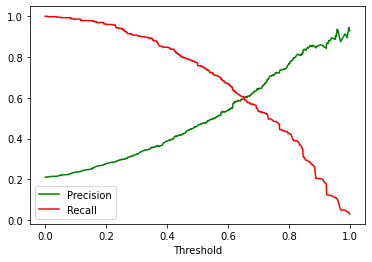

In [66]:
#перебор порогов на основе валид. фич, на классе 1,
features_valid_scores = model_forest_depth.predict_proba(features_valid)[:, 1] 

#строим кривые
precision, recall, thresholds = precision_recall_curve(target_valid, features_valid_scores)

#задаем параметры графика
plt.plot(thresholds, precision[:-1], "g-", label="Precision")
plt.plot(thresholds, recall[:-1], "r-", label="Recall")
plt.xlabel("Threshold")
plt.legend()
plt.show()

In [67]:
#рассчитываем, при каких значениях метрик получаем максимальный F1
f_1 = 0
thho = 0
answer = 2 * (precision * recall) / (precision + recall)
for i in range(len(thresholds)):
    if answer[i] > f_1:
        f_1 = answer[i]
        thho = thresholds[i]
        prec = precision[i]
        rec = recall[i]

print("Максимальное значение метрики F1 для выборки, равное", f_1, ', достигается при значении порога', thho,
'.\nЗначение precision равно', prec, '.\nЗначение recall', rec)


Максимальное значение метрики F1 для выборки, равное 0.6056497175141243 , достигается при значении порога 0.6208791208791209 .
Значение precision равно 0.5775862068965517 .
Значение recall 0.6365795724465558


При достаточно высоком F1, получили слабые метрики `precision` и `recall`. 

#### Логистическая регрессия

In [68]:
model = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0.0, 0.6, 0.05):
    predicted_valid = probabilities_one_valid > threshold 
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, | f1 = {:.3f}".format(
        threshold, precision, recall, f1))

Порог = 0.00 | Точность = 0.210, Полнота = 1.000, | f1 = 0.348
Порог = 0.05 | Точность = 0.236, Полнота = 0.981, | f1 = 0.380
Порог = 0.10 | Точность = 0.280, Полнота = 0.903, | f1 = 0.427
Порог = 0.15 | Точность = 0.333, Полнота = 0.815, | f1 = 0.473
Порог = 0.20 | Точность = 0.386, Полнота = 0.698, | f1 = 0.497
Порог = 0.25 | Точность = 0.427, Полнота = 0.608, | f1 = 0.502
Порог = 0.30 | Точность = 0.490, Полнота = 0.518, | f1 = 0.503
Порог = 0.35 | Точность = 0.524, Полнота = 0.420, | f1 = 0.466
Порог = 0.40 | Точность = 0.558, Полнота = 0.354, | f1 = 0.433
Порог = 0.45 | Точность = 0.586, Полнота = 0.283, | f1 = 0.381
Порог = 0.50 | Точность = 0.626, Полнота = 0.219, | f1 = 0.324
Порог = 0.55 | Точность = 0.691, Полнота = 0.159, | f1 = 0.259


При пороге 0.3 метрика F1 показывает значение 0.503.

Изменение значения порога хоть и влияет достаточно сильно на значение метрики F1, но все же в меньшей степени, чем, например, баланс веса класса.

### Выбор лучшей модели:

In [69]:
display(df_pred_results)
display(balance)
display(upsample_table)

,Model,F1,Accuracy,Depth,Estimators,AUC-ROC
0,Логистическая регрессия,0.323944,0.8080,-,-,0.771789
1,Дерево решений,0.609987,0.8555,7,-,0.845711
2,Случайный лес,0.588064,0.8585,-,21,0.829789
3,Случайный лес с глубиной,0.601481,0.8655,15,21,0.837701


,Model,F1,Accuracy,Depth,Estimators,AUC-ROC
0,Логистическая регрессия,0.508044,0.709500,-,-,0.776072
1,Дерево решений,0.593002,0.779000,7,-,0.843009
2,Случайный лес,0.582609,0.856000,-,11,0.826596
3,Случайный лес с глубиной,0.640777,0.833500,8,66,0.862640


,Model,F1,Accuracy,Depth,Estimators,AUC-ROC
0,Логистическая регрессия,0.506780,0.709000,-,-,0.776053
1,Дерево решений,0.593346,0.780000,7,-,0.842775
2,Случайный лес,0.608345,0.854500,-,27,0.838481
3,Случайный лес с глубиной,0.629263,0.831500,10,26,0.855558


Самыми высокими показателями метрик F1 и AOC-ROC является случайный лес с глубиной 8 и 66 деревьями, со сбалансированным весом классов.

In [70]:
model_forest_depth = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=66, max_depth=8, class_weight='balanced') #модель леса с меняющимся количеством деревьев и глубиной
model_forest_depth.fit(features_train, target_train) #обучение модели на тренировочной выборке
predictions_forest_depth_valid = model_forest_depth.predict(features_valid) #предсказание на основе валидационных признаков
accuracy_valid_forest_depth = accuracy_score(target_valid, predictions_forest_depth_valid) #accuracy
f1_valid_forest_depth = f1_score(target_valid, predictions_forest_depth_valid) #f1
print("F1:", f1_valid_forest_depth, '\nAccuracy:', accuracy_valid_forest_depth) #вывод

F1: 0.6407766990291263 
Accuracy: 0.8335


### Выводы по разделу борьбы с дисбалансом классов

На данном этапе, борьбе с  дисбалансом, было использовано несколько приемов:
- балансировка веса классов,
- увеличение выборки,
- уменьшение выборки,
- изменение значения порога.

Не все методы прошли проверку, как и не все модели показали достаточно высокое значение метрики F1. 

Выбрана наилучшая модель для проверки на тестовой выборке.

## Тестирование модели

In [71]:
model_forest_depth_best = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=66, max_depth=8, class_weight='balanced') #модель леса с меняющимся количеством деревьев и глубиной
model_forest_depth_best.fit(features_train, target_train) #обучение модели на тренировочной выборке
predictions_forest_depth_test_best = model_forest_depth_best.predict(features_test) #предсказание на основе валидационных признаков
accuracy_test_forest_depth_best = accuracy_score(target_test, predictions_forest_depth_test_best) #accuracy
f1_test_forest_depth_best = f1_score(target_test, predictions_forest_depth_test_best) #f1
print("F1:", f1_test_forest_depth_best, '\nAccuracy:', accuracy_test_forest_depth_best) #вывод

F1: 0.6134831460674158 
Accuracy: 0.828


In [72]:
#вывод таблицы метрик
print(metrics.classification_report(target_test, predictions_forest_depth_test_best, digits=3))

              precision    recall  f1-score   support

           0      0.904     0.875     0.889      1580
           1      0.581     0.650     0.613       420

    accuracy                          0.828      2000
   macro avg      0.742     0.763     0.751      2000
weighted avg      0.836     0.828     0.831      2000



### Вывод по тесту модели

Модель случайного леса с гиперпараметрами `n_estimators`=66, `max_depth`=8 и `class_weight`=`balanced` протестирована на тестовом наборе данных, при этом, получено значение метрики `F1`=0.613, что удовлетворяет поставленной задаче.

## Исследование метрики `AUC-ROC` на тестовой модели

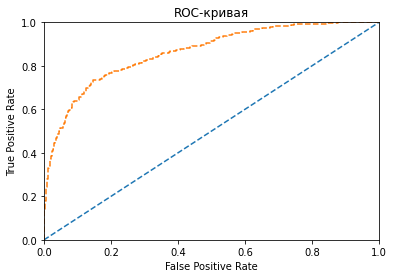

In [73]:
probabilities_valid = model_forest_depth_best.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.plot(fpr, tpr, linestyle='--')

plt.show()

In [74]:
roc_auc_score(target_valid, model_forest_depth_best.predict_proba(features_valid)[:, 1]) #значение roc_auc

0.862640445635185

### Вывод по метрике `AUC-ROC`

ROC-кривая показала хороший результат, а значение `AUC-ROC` - достаточно высокое. Модель хорошо работает.

## Общий вывод

В проекте нужно было спрогнозировать по имеющимся данным, уйдет ли в ближайшее время клиент, или нет.

Для решения были проведены стандартные действия по подготовке данных и их предобработке: 
- импортированы необходимые библиотеки, 
- обозначены признаки и целевой признак,
- проведена проверка на дубликаты, заполнение отсутствующих данных и удаление лишних.

Для подготовки датасета к машинному обучению также были:
- преобразованы классы с помощью прямого кодирования, 
- исходный датасет разделен на необходимые выборки в нужных пропорциях, выделены целевой признак и признаки выборок,
- проведено пробное обучение для того, чтобы понять, имеются ли ошибки датасета или нет,
- признаки были отмасштабированы, для того, чтобы числовые значения не перевешивали своей значимостью категориальные значения.

На этом этапе мы оценили баланс классов целевого признака для каждой выборки и убедились, что имеется значительный дисбаланс.

Далее, мы обучали несколько видов моделей, варьируя их гиперпараметры, но не работая с исправлением дисбаланса классов. На этом этапе очень плохо себя показала логистическая регрессия, с результатом, меньшим, чем у остальных моделей, почти в два раза. Наилучший результат показало дерево решений с заданной глубиной со значением метрики `F1` = 0.61. 

Параметры дерева: 
- `F1` = 0.61, 
- `Accuracy` = 0.856,
- `Depth` 7.

К тому же мы выяснили, что параметрами, оказывающее наибольшее влияние, являются:

- `Age` около 0.22,
- `NumOfProducts`, `Balance`, `CreditScore`, `CustomerId` и `EstimatedSalary` со значением, близким к 0.12
- остальные признаки имеют значимость от 0.06 до 0.01.

Для борьбы с дисбалансом мы применяли разные параметры, такие как: `class_weight = balanced`, `upsampling`, `downsampling` и изменение значение порога `threshold`.

Самые высокие показатели для F1 с балансом классов `class_weight = balanced` на лучшей модели. Также высокие значения показывает `upsampling`.

Лучшей моделью снова стал случайный лес с глубиной: с параметром `class_weight = balanced`, со значением метрики `F1` ~ 0.641. 

Так, выбранная модель для теста - случайный лес с глубиной. Параметры:
- `Depth` 8,
- `Estimators` 66,
- `class_weight = balanced`.

Модель протестирована на тестовых данных и показала значение метрики `F1` = 0.613, что удовлетворяет поставленному условию (> 0.59).

Исследована метрика `AUC-ROC`, найдено значение площади `AUC-ROC` ~0.863, что является высоким показателем, а значит, модель работает достаточно хорошо. 